# Project description
Urban mobility significantly contributes to global environmental impact. With the growth in urbanareas worldwide, cities are implementing policies to focus on sustainable urban and mobility devel-opment. Urban areas exhibit high variability in structure, economic output, mobility behaviour,among others. Pinpointing to the exact causes of emissions is impossible. However, understandingthe relationship of mobility with infrastructure resources and other urban indicators may help gov-ernments predict long-term mobility behaviour and intervene with future pathways into sustainablemobility options. </br>

Project goals: You are tasked to identify how mobility is related to the infrastructural form of acity and across multiple cities. Use your findings toward helping governments transform mobilitywithin cities for reducing environmental impacts of mobility use.
Data: </br>
1. Local city-wide indicators of urban mobility: Multi-city Traffic Datasetprovided publicly byThe Institute for Transport Planning and Systems at ETH Zurich.
2. Global city-wide indicators of urban mobility and environmental impacts:Urban TypologiesProject[Reference]3.Get indicators for infrastructure resources from OSMNX (street networks) and PYROSM(amenities and points of interest) python packages.High-level project goals1.Explore, Investigate, and Visualize various factors of the mobility data across cities of interest.2.Describe and incorporate additional data sources that you will use to help you understandrelationships between mobility and the built environment.
3. Identify correlations between mobility and the built environment.4.Perform clustering or LISA analysis on city streets where congestion may be related stronglywith the presence of certain amenities. Think about how that may vary with distance toamenities.
4. Or, train and evaluate models using the mobility data (either as predictors or as the primaryresponse in some fashion) and your data sources.
6. Use and interpret your models to discuss the causes and correlations of or effects due todifferences in congestion across cities or within a city of your choice.
7. Aggregate city-wide findings to correlate with environmental indicators used in data set (2) -urban typology - to comment on policy initiatives of the governments. (Think how you mayaggregate city-wide findings to a single score for the whole city to compare with indicatorsused in data set 

(2))Note: Not all data may be available for all cities. Hence, conduct this analysis for at least5citiesoverlapping between sets1and2in the data. You are welcome to do the analysis in many morecities.


In [348]:
# import 
import pandas as pd
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt
import numpy as np
import pyrosm as py
import seaborn as sns
import pickle
import contextily as ctx
from sklearn import cluster
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split


### Load graphs

In [2]:
UTD19 = pd.read_csv('Data/detectors_public.csv') # read big file with all cities 
newcitylist= [ 'munich', 'rotterdam', 'frankfurt', 'hamburg', 'zurich'] # find only our cities for now, store in dataframe
UTD19Cities = UTD19.loc[UTD19.citycode.isin(newcitylist)] # UTD19Cities is dataframe

In [3]:
def GetGraphs(df):
    # function designed to extract bbox and create graphs with bbox
    clist = df.citycode.unique()
    GraphList = []
    for i in clist:
        maxlonglt = df.loc[df.citycode == i, ['long', 'lat']].max() # maxlonglat[0] = long, 1 lat
        minlonglt = df.loc[df.citycode == i, ['long', 'lat']].min() #
        north = maxlonglt[1] 
        south = minlonglt[1]
        east = maxlonglt[0]
        west = minlonglt[0]
        A = ox.graph.graph_from_bbox(north, south, east, west, network_type='drive')
        GraphList.append(A)
    return GraphList
        
Graphs = GetGraphs(UTD19Cities)

### Load POIS

In [4]:
# de filepaths zin nu specifiek voor mijn computer, moet je zelf even aanpassen naar waar die van jou staan
fp_rotterdam ="data/rotterdam.osm.pbf"
fp_munich ="data/munich.osm.pbf"
fp_zurich ="data/zurich.osm.pbf"
fp_hamburg ="data/hamburg.osm.pbf"
fp_frankfurt ="data/frankfurt.osm.pbf"

In [5]:
#alternative transport options

"""
PoisDic = dict()
for i,v in [(fp_rotterdam, 'rotterdam'), (fp_munich, 'munich') , (fp_zurich, 'zurich'), (fp_hamburg, 'hamburg'), (fp_frankfurt, 'frankfurt')]:    # Initiliaze with bounding box
    osm = py.OSM(filepath=i)

    # By default pyrosm reads all elements having "amenity", "shop" or "tourism" tag
    # Here, let's read only "amenity" and "shop" by applying a custom filter that
    # overrides the default filtering mechanism
    custom_filter = {'public_transport': ['station'], 'highway': ['pedestrian', 'footway', 'cycleway', 'busway']}
    pois = osm.get_pois(custom_filter=custom_filter)

    # Gather info about POI type (combines the tag info from "amenity" and "shop")
    pois["public_transport"] = pois["public_transport"].fillna(" ")
    pois["highway"] = pois["highway"].fillna(" ")
    pois["poi_type"] = pois["highway"] + pois['public_transport']
    
    # save pois in dict
    PoisDic[v] = pois

    # Plot
    ax = pois.plot(column='poi_type', markersize=3, figsize=(12,12), legend=True, legend_kwds=dict(loc='upper left', ncol=5, bbox_to_anchor=(1, 1)))
    ax.set_title(v)
    pois.head()

"""

'\nPoisDic = dict()\nfor i,v in [(fp_rotterdam, \'rotterdam\'), (fp_munich, \'munich\') , (fp_zurich, \'zurich\'), (fp_hamburg, \'hamburg\'), (fp_frankfurt, \'frankfurt\')]:    # Initiliaze with bounding box\n    osm = py.OSM(filepath=i)\n\n    # By default pyrosm reads all elements having "amenity", "shop" or "tourism" tag\n    # Here, let\'s read only "amenity" and "shop" by applying a custom filter that\n    # overrides the default filtering mechanism\n    custom_filter = {\'public_transport\': [\'station\'], \'highway\': [\'pedestrian\', \'footway\', \'cycleway\', \'busway\']}\n    pois = osm.get_pois(custom_filter=custom_filter)\n\n    # Gather info about POI type (combines the tag info from "amenity" and "shop")\n    pois["public_transport"] = pois["public_transport"].fillna(" ")\n    pois["highway"] = pois["highway"].fillna(" ")\n    pois["poi_type"] = pois["highway"] + pois[\'public_transport\']\n    \n    # save pois in dict\n    PoisDic[v] = pois\n\n    # Plot\n    ax = pois.

In [6]:
#PoisDic['rotterdam'].head() # stored in dataframe

# Save POI pickle

In [7]:
#with open('POI.pickle', 'wb') as handle:
#    pickle.dump(PoisDic, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
## Load POI pickle
# Load data (deserialize)
with open('POI.pickle', 'rb') as handle:
    poi_dic = pickle.load(handle)

### Load pickle

In [9]:
# Load data (deserialize)
with open('Edges.pickle', 'rb') as handle:
    dic = pickle.load(handle)

dic['rotterdam'].head()


,osmid,name,highway,oneway,length,bridge,geometry,maxspeed,lanes,ref,junction,tunnel,access,u,v,key,detid
0,"[311806104, 311806106, 321898179]",'s-Gravenweg,residential,False,88.311,yes,"LINESTRING (4.52452 51.92392, 4.52412 51.92331...",NaN,NaN,NaN,NaN,NaN,NaN,44417024,771255062,0,NaN
1,7514536,Frans Bekkerstraat,residential,False,61.119,NaN,"LINESTRING (4.46527 51.89180, 4.46613 51.89165)",NaN,NaN,NaN,NaN,NaN,NaN,44269570,44269098,0,NaN
2,7515679,Frans Bekkerstraat,residential,False,76.835,NaN,"LINESTRING (4.46527 51.89180, 4.46496 51.89218...",50,NaN,NaN,NaN,NaN,NaN,44269570,963879003,0,NaN
3,"[7515714, 7515628]",Verboomstraat,residential,False,145.552,NaN,"LINESTRING (4.46527 51.89180, 4.46528 51.89177...",50,NaN,NaN,NaN,NaN,NaN,44269570,44262667,0,NaN
4,7319072,Schultz van Hagenstraat,residential,False,48.438,NaN,"LINESTRING (4.52872 51.92385, 4.52848 51.92344)",NaN,NaN,NaN,NaN,NaN,NaN,44417028,44412933,0,NaN


### Load flows

In [10]:
data_frankfurt = pd.read_csv('data\\UTD_f.csv')
data_hamburg = pd.read_csv('data/UTD_h.csv')
data_munich = pd.read_csv('data\\UTD_m.csv')
data_rotterdam = pd.read_csv('data\\UTD_r.csv')
data_zurich = pd.read_csv('data\\UTD_z.csv')

In [11]:
frankfurt_detid_average = (data_frankfurt.groupby('detid').flow.mean()).to_frame(name = None)
hamburg_detid_average = (data_hamburg.groupby('detid').flow.mean()).to_frame(name = None)
munich_detid_average = (data_munich.groupby('detid').flow.mean()).to_frame(name = None)
rotterdam_detid_average = (data_rotterdam.groupby('detid').flow.mean()).to_frame(name = None)
zurich_detid_average = (data_zurich.groupby('detid').flow.mean()).to_frame(name = None)

In [12]:
frankfurt_detid_average['city'] = 'frankfurt'
hamburg_detid_average['city'] = 'hamburg'
munich_detid_average['city'] = 'munich'
rotterdam_detid_average['city'] =  'rotterdam'
zurich_detid_average['city'] = 'zurich'

In [13]:
# most Functions dont use this
Mean_perdetid = pd.concat([frankfurt_detid_average,
                                  hamburg_detid_average,
                                  munich_detid_average,
                                  rotterdam_detid_average,
                                  zurich_detid_average])
          

In [14]:
result = Mean_perdetid.to_csv('data\\UTD_Mean_Flow_per_detid.csv', index = True)#exporting data frame as csv file.

### Load flows as edge atributes

In [15]:
# try plotting the flow on the OSMNX graph
hamburg_detid_average.reset_index(inplace = True)
frankfurt_detid_average.reset_index(inplace = True)
munich_detid_average.reset_index(inplace = True)
rotterdam_detid_average.reset_index(inplace = True)
zurich_detid_average.reset_index(inplace = True)

#df['ColumnID'] = df['ColumnID'].astype(str)
munich_detid_average.detid = munich_detid_average.detid.astype(str)

In [16]:
H = dic['hamburg']
def Match(detid, df):
    if type(detid) == str:
        flowval = df.loc[df.detid == detid, 'flow'].values # get specific value
        try:
            flowval = float(flowval) # convert array to float
            return flowval
        except:
            # list empty
            return np.nan
    
    
H['flow'] = H['detid'].apply(Match, args = [hamburg_detid_average])
#H['detid'].apply(Match, args = [hamburg_detid_average])
    

In [17]:
F = dic['frankfurt']
# H = dic['Hamburg'] # skip, allready done
M = dic['munich']
R = dic['rotterdam']
Z = dic['zurich']

F['flow'] = F['detid'].apply(Match, args = [frankfurt_detid_average])
M['flow'] = M['detid'].apply(Match, args = [munich_detid_average])
R['flow'] = R['detid'].apply(Match, args = [rotterdam_detid_average])
Z['flow'] = Z['detid'].apply(Match, args = [zurich_detid_average])
H['flow'] = H['detid'].apply(Match, args = [hamburg_detid_average])


In [471]:
F.head()

,osmid,oneway,lanes,ref,name,highway,maxspeed,length,geometry,access,...,junction,tunnel,u,v,key,detid,flow,x,y,city
0,42367702,True,2,B 44,Platz der Republik,primary,50,13.290,"LINESTRING (8.66082 50.10948, 8.66068 50.10956)",NaN,...,NaN,NaN,162595,495023287,0,NaN,NaN,8.660750,50.109525,frankfurt
1,42368106,True,2,NaN,Mainzer Landstraße,primary,50,216.018,"LINESTRING (8.66082 50.10948, 8.66093 50.10954...",NaN,...,NaN,NaN,162595,604188,0,NaN,NaN,8.662094,50.110015,frankfurt
2,4514490,True,NaN,NaN,Weserstraße,residential,NaN,7.553,"LINESTRING (8.66636 50.11180, 8.66641 50.11174)",NaN,...,NaN,NaN,558661,613254,0,NaN,NaN,8.666385,50.111771,frankfurt
3,49967814,True,2,NaN,Mainzer Landstraße,primary,NaN,255.460,"LINESTRING (8.66636 50.11180, 8.66620 50.11173...",NaN,...,NaN,NaN,558661,558662,0,NaN,NaN,8.664836,50.111187,frankfurt
4,39503239,False,NaN,NaN,Westendstraße,residential,NaN,9.859,"LINESTRING (8.66331 50.11060, 8.66338 50.11052)",NaN,...,NaN,NaN,558662,604188,0,NaN,NaN,8.663342,50.110560,frankfurt


In [18]:
"""
f, ax = plt.subplots(figsize=(9,9))
pois = PoisDic['frankfurt']
pois['x'] = pois.geometry.centroid.x
pois['y'] = pois.geometry.centroid.y
sns.scatterplot(x = 'x', y = 'y', ax = ax, data = pois, hue = pois['poi_type'].to_list())
F['x'] = F.geometry.centroid.x
F['y'] = F.geometry.centroid.y
flows = sns.scatterplot(x = 'x', y = 'y', ax =ax , data = F, hue = F['flow'].to_list(), size = F['flow'].to_list())
#plt.colorbar(flows)
#ax.legend()
"""

"\nf, ax = plt.subplots(figsize=(9,9))\npois = PoisDic['frankfurt']\npois['x'] = pois.geometry.centroid.x\npois['y'] = pois.geometry.centroid.y\nsns.scatterplot(x = 'x', y = 'y', ax = ax, data = pois, hue = pois['poi_type'].to_list())\nF['x'] = F.geometry.centroid.x\nF['y'] = F.geometry.centroid.y\nflows = sns.scatterplot(x = 'x', y = 'y', ax =ax , data = F, hue = F['flow'].to_list(), size = F['flow'].to_list())\n#plt.colorbar(flows)\n#ax.legend()\n"

In [19]:
FlowDict = {'rotterdam':R ,'zurich': Z,'munich':M, 'frankfurt':F, 'hamburg':H}

def CreatePlots(GList, PDict, Clist = UTD19Cities.citycode.unique(), flowdict = FlowDict): 
    # need to run UTD19Cities, GetGraphs and need the POIS Dic
    for number,city in enumerate(Clist):
        GraphCity = GList[number]
        # plot build enviroment vs traffic flows 
        pois = PoisDic[city]
        pois['x'] = pois.geometry.centroid.x
        pois['y'] = pois.geometry.centroid.y
        
        N_d, remove = ox.graph_to_gdfs(GraphCity)
        Edge_df = FlowDict[city] # retrieve edge data
        Edge_df['flow'] = Edge_df.flow.fillna(0) # necessary for plotting colors
        New = ox.graph_from_gdfs(N_d, Edge_df, graph_attrs={'edge_attr': ['detid', 'flow']} )
        New.graph['crs'] = GraphCity.graph['crs']

        # setup plot
        f, ax = plt.subplots(figsize = (10,10))
        ec = ox.plot.get_edge_colors_by_attr(New, attr='flow', cmap='Purples') # set color scale by atribute (now length could be any other variable)
        z = ox.plot_graph(New, edge_color= ec, node_size=1, ax =ax, show = False, close = False) # edgecolor is stored in ec
        # uncomment line below if build enviroment also neccessary
        #sns.scatterplot(x = 'x', y = 'y', ax = ax, data = pois , hue = pois['poi_type'].to_list(), alpha = 0.3, size = 0.3)
 
        
#CreatePlots(Graphs, PoisDic)

# Spatial weights (rough)
Example FrankFurt

In [20]:
# retrieve Pois dic
#pois = PoisDic['frankfurt']
#pois.crs # crs is still in degrees -> reprojection necessary

In [21]:
#pois = pois.to_crs('EPSG:4839')
#pois.crs # worked, now in metres

In [22]:
from pysal.lib import weights
# get projections in meters
#pois['X'] = pois.geometry.centroid.x
#pois['Y'] = pois.geometry.centroid.y

# calculate using array, if binary = True -> 1 if neighbour, threshold in meters
#w = weights.distance.DistanceBand.from_array(pois[['X','Y']], threshold = 250, binary = False) 
#w[0] # example of w

NameError: name 'pois' is not defined

In [ ]:
# Validation of W
# Setup figure
"""
f, ax = plt.subplots(1, figsize=(9, 9))
# get neighbours
neis = w[300]
pois['neis'] = 0

for key in neis.keys():
    pois.loc[key,'neis'] = 1 # if neighbour is 1, otherwise 0 
# Plot base layer of polygons
sns.scatterplot(x= 'X', y = 'Y', ax=ax, data = pois, hue = pois['neis'].to_list())
# get first one -> plot in red
data = pois.iloc[300][['X','Y']]
ax.scatter(data.X, data.Y, color = 'red')
"""

### count point inside buffer and stuff

#### create geodf with all pois and cities

In [209]:
#unpack poi dic 
Fpois = poi_dic['frankfurt']
Rpois = poi_dic['rotterdam']
Hpois = poi_dic['hamburg']
Mpois = poi_dic['munich']
Zpois = poi_dic['zurich']
    

In [210]:
# addcityname column

Fpois['city'] = 'frankfurt'
Rpois['city'] = 'rotterdam'
Hpois['city'] = 'hamburg'
Mpois['city'] = 'munich'
Zpois['city'] = 'zurich'

In [213]:
# add all to same df
pois_cities = pd.concat([Fpois, Rpois, Hpois, Mpois, Zpois])

In [218]:
pois_cities.columns

Index(['lat', 'changeset', 'id', 'timestamp', 'tags', 'version', 'lon',
       'addr:city', 'addr:postcode', 'addr:street', 'name', 'operator',
       'public_transport', 'station', 'tunnel', 'geometry', 'osm_type',
       'access', 'area', 'bicycle', 'bridge', 'foot', 'footway', 'highway',
       'lit', 'motor_vehicle', 'oneway', 'segregated', 'smoothness', 'surface',
       'width', 'cycleway', 'sidewalk', 'poi_type', 'x', 'y', 'city',
       'addr:country', 'ref', 'junction', 'lanes', 'maxspeed', 'motorcar',
       'service', 'tracktype', 'website', 'opening_hours', 'url',
       'addr:housenumber', 'bicycle_road', 'est_width', 'overtaking', 'psv',
       'path'],
      dtype='object')

#### create geodf with all detectors, flows and cities

In [ ]:
UTD19 = pd.read_csv('Data/detectors_public.csv') # read big file with all cities 
newcitylist= [ 'munich', 'rotterdam', 'frankfurt', 'hamburg', 'zurich'] # find only our cities for now, store in dataframe
UTD19Cities = UTD19.loc[UTD19.citycode.isin(newcitylist)] # UTD19Cities is dataframe
df2 = UTD19Cities.loc[UTD19Cities.citycode == 'frankfurt']

In [244]:
Fflow = UTD19Cities.loc[UTD19Cities.citycode == 'frankfurt']
Rflow = UTD19Cities.loc[UTD19Cities.citycode == 'rotterdam']
Hflow = UTD19Cities.loc[UTD19Cities.citycode =='hamburg']
Mflow = UTD19Cities.loc[UTD19Cities.citycode =='munich']
Zflow = UTD19Cities.loc[UTD19Cities.citycode =='zurich']

In [245]:
Fflow['city'] = 'frankfurt'
Rflow['city'] = 'rotterdam'
Hflow['city'] = 'hamburg'
Mflow['city'] = 'munich'
Zflow['city'] = 'zurich'

C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [253]:
Fflow['flow'] = Fflow['detid'].apply(Match, args = [frankfurt_detid_average])
Mflow['flow'] = Mflow['detid'].apply(Match, args = [munich_detid_average])
Rflow['flow'] = Rflow['detid'].apply(Match, args = [rotterdam_detid_average])
Zflow['flow'] = Zflow['detid'].apply(Match, args = [zurich_detid_average])
Hflow['flow'] = Hflow['detid'].apply(Match, args = [hamburg_detid_average])

C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [254]:
flow_cities = pd.concat([Fflow, Rflow, Mflow, Zflow, Hflow])

In [255]:
flow_cities.head()

,detid,length,pos,fclass,road,limit,citycode,lanes,linkid,long,lat,city,flow
3441,STA4_D1(KFZ1),0.129484,0.039710,primary,Stresemannallee,50,frankfurt,1.0,59.0,8.670011,50.097966,frankfurt,184.139373
3442,STA4_D1a(KFZ1),0.131666,0.041698,primary,Stresemannallee,50,frankfurt,1.0,60.0,8.670057,50.097985,frankfurt,160.647887
3443,STA4_D2(KFZ2),0.131590,0.042400,primary,Stresemannallee,50,frankfurt,1.0,61.0,8.670108,50.098007,frankfurt,203.034965
3444,STA4_D2a(KFZ2),0.077419,0.041444,primary,Stresemannallee,50,frankfurt,1.0,62.0,8.670148,50.098026,frankfurt,207.872340
3445,STA4_D8a(KFZ8),0.254428,0.025927,primary,Kennedyallee,50,frankfurt,1.0,52.0,8.670210,50.096997,frankfurt,241.062731


#### Create dataframe suitable for analyzing

In [256]:
pois_cities['x'] = pois_cities.geometry.centroid.x
pois_cities['y'] = pois_cities.geometry.centroid.y

C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.
C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [257]:
flow_cities = gpd.GeoDataFrame(
    flow_cities, geometry=gpd.points_from_xy(flow_cities.long, flow_cities.lat))
flow_cities.set_crs(epsg=4326, inplace=True, allow_override=True)
pois_meters = pois_cities.to_crs(epsg=4839)
flow_meters = flow_cities.to_crs(epsg=4839)

In [323]:
#flow_meters.info()

In [322]:
#pois_meters.info()

#### Functions for counting, clustering and regression

In [276]:
def count_all_pois(pois_df, flow_df):
    flow_df['buffer_500m'] = flow_df.buffer(500)
    joined = gpd.sjoin(pois_df,
                    flow_df.set_geometry('buffer_500m')[['detid', 'buffer_500m']],
                    op="within"
                   )
    poi_count = joined.groupby("detid")["poi_type"].count().to_frame('poi_count')
    flow_pois = flow_df.merge(poi_count, left_on='detid', right_index=True)\
                                 .fillna({"poi_count": 0})
    return flow_pois

poi_counts = count_all_pois(pois_meters, flow_meters)


In [331]:
#poi_counts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2330 entries, 3441 to 4326
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   detid        2330 non-null   object  
 1   length       2330 non-null   float64 
 2   pos          2330 non-null   float64 
 3   fclass       2330 non-null   object  
 4   road         2276 non-null   object  
 5   limit        2330 non-null   object  
 6   citycode     2330 non-null   object  
 7   lanes        2330 non-null   float64 
 8   linkid       2330 non-null   float64 
 9   long         2330 non-null   float64 
 10  lat          2330 non-null   float64 
 11  city         2330 non-null   object  
 12  flow         2329 non-null   float64 
 13  geometry     2330 non-null   geometry
 14  buffer_500m  2330 non-null   geometry
 15  poi_count    2330 non-null   int64   
dtypes: float64(7), geometry(2), int64(1), object(6)
memory usage: 309.5+ KB


<AxesSubplot:xlabel='flow', ylabel='poi_count'>

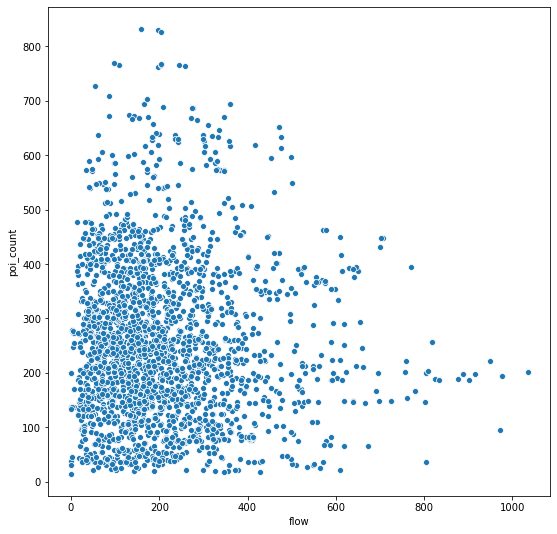

In [277]:
f, ax = plt.subplots(figsize=(9, 9))

sns.scatterplot(x = poi_counts['flow'], y = poi_counts['poi_count'],  ax=ax)

In [453]:
def count_per_poi(pois_df_meters, flow_df_meters, flow_df):
    flow_df['buffer_500m'] = flow_df_meters.buffer(500)
    joined = gpd.sjoin(pois_df_meters,
                    flow_df_meters.set_geometry('buffer_500m')[['detid', 'buffer_500m']],
                    op="within"
                   )
    poi_count_stations = joined.groupby(['detid', 'poi_type'])['poi_type'].count()
    poi_count_stations = poi_count_stations.unstack()
    
    # merge flows with counts per poi
    flow_perpoi = flow_df.merge(poi_count_stations, left_on='detid', right_index=True)
    
    #tidy
    flow_perpoi=flow_perpoi.rename(columns={"pedestrian ": "pedestrian", ' station':'station', 'cycleway ': 'cycleway', 'footway ':'footway'})
    flow_perpoi = flow_perpoi.fillna(value = {"pedestrian": 0, "station" : 0, "cycleway":0, "footway":0})
    
    return flow_perpoi

flow_perpoi = count_per_poi(pois_meters, flow_meters, flow_cities)

In [454]:
flow_perpoi = flow_perpoi[flow_perpoi['flow'].notna()]

In [344]:
var_array = ['station', 'flow', 'cycleway', 'footway', 'pedestrian']
Rflowandpoi=flow_perpoi[flow_perpoi['city']=='rotterdam']

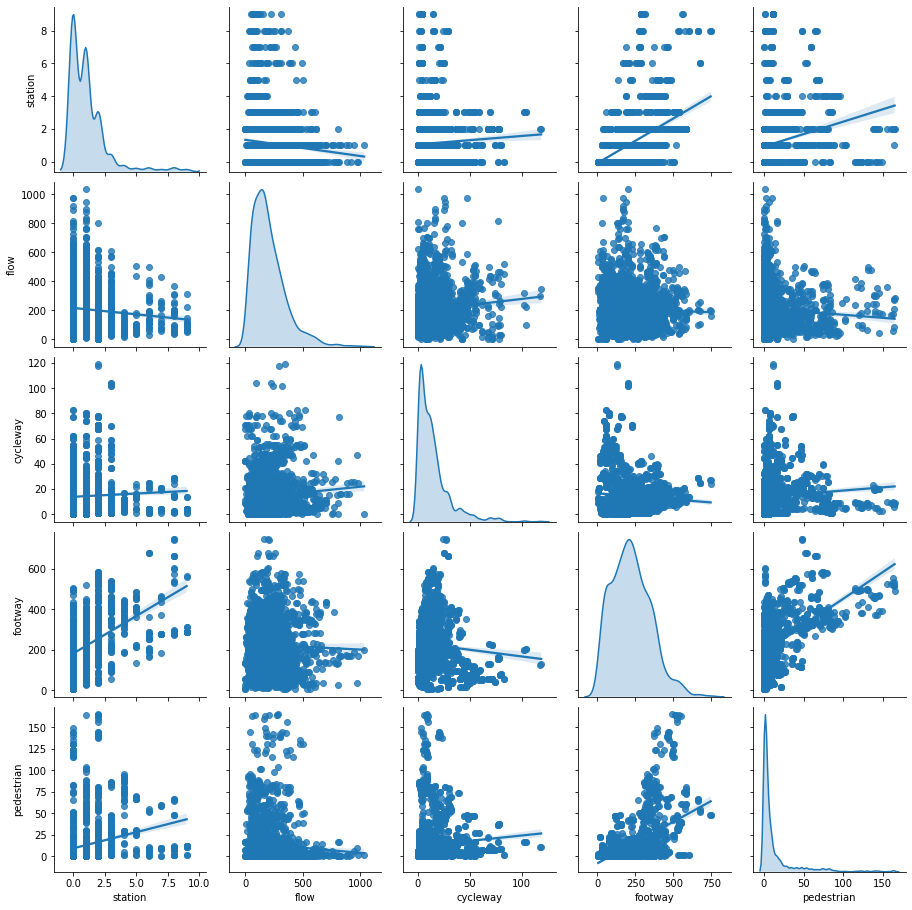

In [470]:
_ = sns.pairplot(flow_perpoi[var_array], kind='reg', diag_kind='kde')

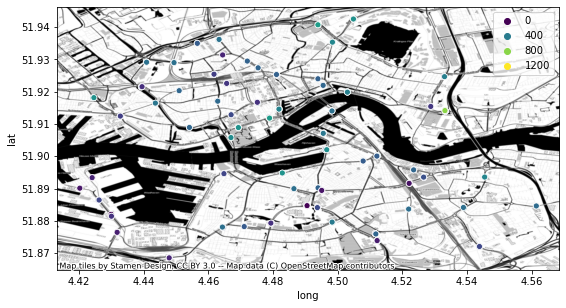

In [466]:
def get_on_map(df_flows_pois, city, column_to_plot):
    f, ax = plt.subplots(1, figsize=(9, 9))
    #df_flows_pois[df_flows_pois['city']== city].plot(column=column_to_plot,
    #                                alpha=0.5,
    #                                legend=True,
    #                                ax=ax
    #                     )
    sns.scatterplot(x = 'long', y = 'lat', ax = ax, data = df_flows_pois[df_flows_pois['city']== city],\
                    hue = df_flows_pois[df_flows_pois['city']== city][column_to_plot].to_list(),\
                    palette = 'viridis')
    plt.axis('scaled')

    
    ctx.add_basemap(ax, 
                    crs=df_flows_pois.crs.to_string(), 
                    source=ctx.providers.Stamen.Toner,
                    )

    
get_on_map(flow_perpoi, 'rotterdam', 'flow')

In [461]:
def clustering(df, var):
    kmeans5 = cluster.KMeans(n_clusters=5)
    np.random.seed(1234)
    k5cls = kmeans5.fit(df[var])
    df['k5cls'] = k5cls.labels_
    return df

cluster_df = clustering(flow_perpoi, var_array)

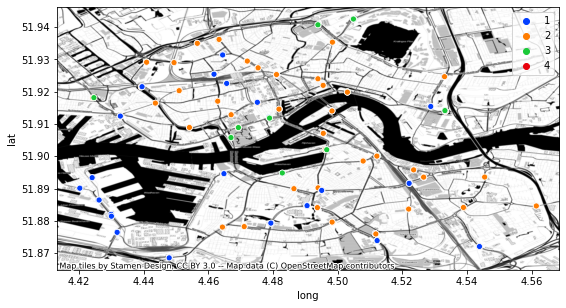

In [462]:
f, ax = plt.subplots(figsize=(9, 9))
sns.scatterplot(x = 'long', y = 'lat', ax = ax, data = cluster_df[cluster_df['city']== 'rotterdam'],\
                hue = cluster_df[cluster_df['city']== 'rotterdam']['k5cls'].tolist(), palette = 'bright')

ctx.add_basemap(ax, 
                      crs=pois_cities.crs.to_string(), 
                       source=ctx.providers.Stamen.Toner
                     )

In [ ]:
def CreatePlots(GList, PDict, Clist = UTD19Cities.citycode.unique(), flowdict = EdgeDict): 
    # need to run UTD19Cities, GetGraphs and need the POIS Dic
    for number,city in enumerate(Clist):
        GraphCity = GList[number]
        # plot build enviroment vs traffic flows 
        pois = PDict[city]
        pois['x'] = pois.geometry.centroid.x
        pois['y'] = pois.geometry.centroid.y
        
        N_d, remove = ox.graph_to_gdfs(GraphCity)
        Edge_df = flowdict[city] # retrieve edge data
        Edge_df['flow'] = Edge_df.flow.fillna(0) # necessary for plotting colors
        New = ox.graph_from_gdfs(N_d, Edge_df, graph_attrs={'edge_attr': ['detid', 'flow']} )
        New.graph['crs'] = GraphCity.graph['crs']

        # setup plot
        f, ax = plt.subplots(figsize = (10,10))
        ec = ox.plot.get_edge_colors_by_attr(New, attr='flow', cmap='Purples') # set color scale by atribute (now length could be any other variable)
        z = ox.plot_graph(New, edge_color= ec, node_size=1, ax =ax, show = False, close = False) # edgecolor is stored in ec
        ax.set_title(city)

In [392]:
# Calculate the mean by group
k5means = cluster_df.groupby('k5cls')[['station', 'flow', 'cycleway', 'footway','pedestrian']].mean()
# Show the table transposed (so it's not too wide)
k5means.T

k5cls,0,1,2,3,4
station,2.021538,0.523077,0.837891,0.817610,1.461230
flow,241.200088,114.135605,302.622989,585.523816,117.237827
cycleway,14.569231,13.446154,17.806641,15.981132,12.649733
footway,425.880000,111.239316,143.710938,214.836478,279.152406
pedestrian,37.984615,4.049573,5.837891,6.062893,16.744652


In [467]:
def regression(y_array, x_array, df):
    
    # the df is split into a training and testing set
    # the test size is 0.2%, since the df is not very large
    traindf, testdf = train_test_split(df, test_size=0.2, random_state=42)
    print(f'Shape of the training set is {traindf.shape} and of the testing set is {testdf.shape}.')
    
    # creates arrays for the predicted variable and the prediction variables
    y_train = traindf[y_array]
    x_train = traindf[x_array]

    y_test = testdf[y_array]
    x_test = testdf[x_array]
    
    
    # create the X matrix by appending a column of ones to x_train and x_test
    train_data_augmented = sm.add_constant(x_train)
    test_data_augmented = sm.add_constant(x_test)

    # build the OLS model (ordinary least squares) from the training data
    OLS_model = sm.OLS(y_train, train_data_augmented)

    # do the fit and save regression info (parameters, etc) in OLS_results
    OLS_results = OLS_model.fit()
    
    # get the prediction results for the test set
    predy_test = OLS_results.predict(test_data_augmented)
    
    return [OLS_results, y_train, x_train, y_test, x_test, predy_test]

regression_model1 = regression(['flow'], ['station', 'cycleway', 'footway', 'pedestrian'], flow_perpoi )

Shape of the training set is (1863, 21) and of the testing set is (466, 21).


In [468]:
print(regression_model1[0].summary())

                            OLS Regression Results                            
Dep. Variable:                   flow   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     10.44
Date:                Sun, 08 Nov 2020   Prob (F-statistic):           2.32e-08
Time:                        10:59:13   Log-Likelihood:                -11892.
No. Observations:                1863   AIC:                         2.379e+04
Df Residuals:                    1858   BIC:                         2.382e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        189.8578      7.792     24.367      0.0

### code is mess

In [23]:
pois = poi_dic['frankfurt']

In [24]:
pois.groupby('poi_type').poi_type.count()


poi_type
 station        12
cycleway        10
footway        459
pedestrian      28
Name: poi_type, dtype: int64

In [43]:
pois['x'] = pois.geometry.centroid.x
pois['y'] = pois.geometry.centroid.y
F['x'] = F.geometry.centroid.x
F['y'] = F.geometry.centroid.y

C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.
C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  
C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:4: Us

In [379]:
filtered_F = F[F['detid'].notnull()]
filter_F = filtered_F[['detid', 'flow', 'x', 'y', 'city' ]]

In [380]:
filter_F.head()

,detid,flow,x,y,city
14,T1_D2,60.129496,8.666159,50.108355,frankfurt
18,STA2_D4(KFZ4),70.794979,8.667279,50.098595,frankfurt
20,WL2_D2(KFZ3),102.202247,8.669478,50.105882,frankfurt
22,G3_D2(KFZ1),254.675958,8.668088,50.105600,frankfurt
35,SD_D1(KFZ1),206.479705,8.673383,50.103486,frankfurt


In [46]:
UTD19 = pd.read_csv('Data/detectors_public.csv') # read big file with all cities 
newcitylist= [ 'munich', 'rotterdam', 'frankfurt', 'hamburg', 'zurich'] # find only our cities for now, store in dataframe
UTD19Cities = UTD19.loc[UTD19.citycode.isin(newcitylist)] # UTD19Cities is dataframe
df2 = UTD19Cities.loc[UTD19Cities.citycode == 'frankfurt']


In [47]:
df2.head()

,detid,length,pos,fclass,road,limit,citycode,lanes,linkid,long,lat
3441,STA4_D1(KFZ1),0.129484,0.039710,primary,Stresemannallee,50,frankfurt,1.0,59.0,8.670011,50.097966
3442,STA4_D1a(KFZ1),0.131666,0.041698,primary,Stresemannallee,50,frankfurt,1.0,60.0,8.670057,50.097985
3443,STA4_D2(KFZ2),0.131590,0.042400,primary,Stresemannallee,50,frankfurt,1.0,61.0,8.670108,50.098007
3444,STA4_D2a(KFZ2),0.077419,0.041444,primary,Stresemannallee,50,frankfurt,1.0,62.0,8.670148,50.098026
3445,STA4_D8a(KFZ8),0.254428,0.025927,primary,Kennedyallee,50,frankfurt,1.0,52.0,8.670210,50.096997


<AxesSubplot:xlabel='long', ylabel='lat'>

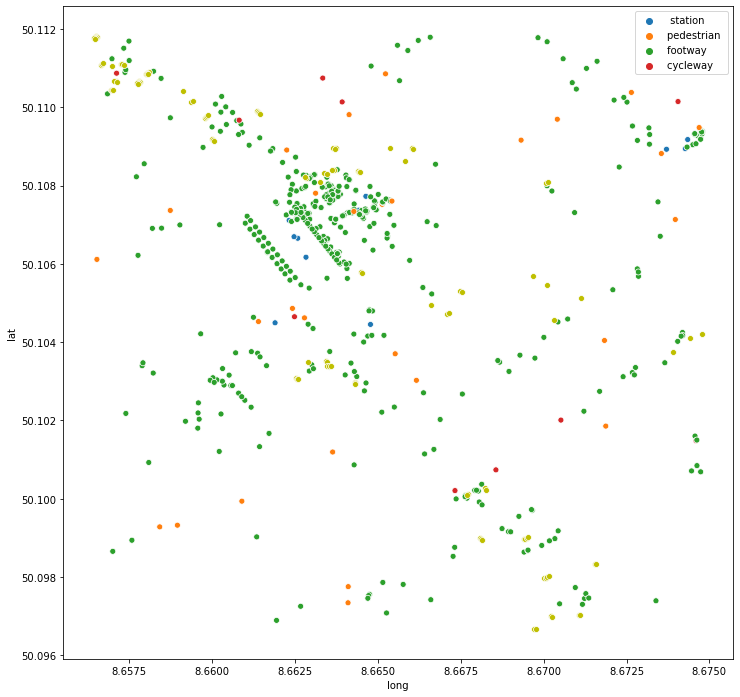

In [48]:
f,ax = plt.subplots(1,figsize=(12, 12))
sns.scatterplot(x = 'x', y = 'y', ax = ax, data = pois, hue = pois['poi_type'].to_list())
sns.scatterplot(x = 'long', y = 'lat', ax = ax, data = df2, color = 'y')

#ctx.add_basemap(ax)


In [55]:
df2_gdf = gpd.GeoDataFrame(
    df2, geometry=gpd.points_from_xy(df2.long, df2.lat))
pois.head()

,lat,changeset,id,timestamp,tags,version,lon,addr:city,addr:postcode,addr:street,...,oneway,segregated,smoothness,surface,width,cycleway,sidewalk,poi_type,x,y
0,50.108929,0.0,140149879,-1,"{""tram"":""yes"",""wheelchair"":""yes""}",0,8.673705,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,station,8.673705,50.108929
1,50.106655,-1.0,205364328,0,"{""note"":""25 tracks with passenger platforms"",""...",0,8.662580,Frankfurt am Main,60329,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,station,8.662580,50.106655
2,50.107113,-1.0,677374148,0,"{""train"":""yes"",""railway"":""station"",""uic_ref"":""...",0,8.662321,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,station,8.662321,50.107113
3,50.108944,-3.0,759943999,-1,"{""subway"":""yes"",""railway"":""tram_stop"",""wheelch...",0,8.674273,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,station,8.674273,50.108944
4,50.107727,-96.0,767185691,0,"{""tram"":""yes"",""railway"":""tram_stop"",""wheelchai...",0,8.664636,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,station,8.664636,50.107727


In [56]:
pois.crs
df2_gdf.crs
df2_gdf.set_crs(epsg=4326, inplace=True, allow_override=True)
pois.head()

,lat,changeset,id,timestamp,tags,version,lon,addr:city,addr:postcode,addr:street,...,oneway,segregated,smoothness,surface,width,cycleway,sidewalk,poi_type,x,y
0,50.108929,0.0,140149879,-1,"{""tram"":""yes"",""wheelchair"":""yes""}",0,8.673705,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,station,8.673705,50.108929
1,50.106655,-1.0,205364328,0,"{""note"":""25 tracks with passenger platforms"",""...",0,8.662580,Frankfurt am Main,60329,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,station,8.662580,50.106655
2,50.107113,-1.0,677374148,0,"{""train"":""yes"",""railway"":""station"",""uic_ref"":""...",0,8.662321,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,station,8.662321,50.107113
3,50.108944,-3.0,759943999,-1,"{""subway"":""yes"",""railway"":""tram_stop"",""wheelch...",0,8.674273,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,station,8.674273,50.108944
4,50.107727,-96.0,767185691,0,"{""tram"":""yes"",""railway"":""tram_stop"",""wheelchai...",0,8.664636,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,station,8.664636,50.107727


In [57]:
pois_meters = pois.to_crs(epsg=4839)
df2_meters = df2_gdf.to_crs(epsg=4839)

In [58]:
pois.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [59]:
pois_meters.crs

<Projected CRS: EPSG:4839>
Name: ETRS89 / LCC Germany (N-E)
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Germany - onshore
- bounds: (5.86, 47.27, 15.04, 55.09)
Coordinate Operation:
- name: LCC Germany
- method: Lambert Conic Conformal (2SP)
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [60]:
df2_meters['buffer_500m'] = df2_meters.buffer(500)
df2_meters.head()

,detid,length,pos,fclass,road,limit,citycode,lanes,linkid,long,lat,geometry,buffer_500m
3441,STA4_D1(KFZ1),0.129484,0.039710,primary,Stresemannallee,50,frankfurt,1.0,59.0,8.670011,50.097966,POINT (-130821.294 -98625.862),"POLYGON ((-130321.294 -98625.862, -130323.702 ..."
3442,STA4_D1a(KFZ1),0.131666,0.041698,primary,Stresemannallee,50,frankfurt,1.0,60.0,8.670057,50.097985,POINT (-130817.960 -98623.788),"POLYGON ((-130317.960 -98623.788, -130320.368 ..."
3443,STA4_D2(KFZ2),0.131590,0.042400,primary,Stresemannallee,50,frankfurt,1.0,61.0,8.670108,50.098007,POINT (-130814.256 -98621.490),"POLYGON ((-130314.256 -98621.490, -130316.663 ..."
3444,STA4_D2a(KFZ2),0.077419,0.041444,primary,Stresemannallee,50,frankfurt,1.0,62.0,8.670148,50.098026,POINT (-130811.330 -98619.461),"POLYGON ((-130311.330 -98619.461, -130313.738 ..."
3445,STA4_D8a(KFZ8),0.254428,0.025927,primary,Kennedyallee,50,frankfurt,1.0,52.0,8.670210,50.096997,POINT (-130809.766 -98733.893),"POLYGON ((-130309.766 -98733.893, -130312.173 ..."


In [63]:
joined = gpd.sjoin(pois_meters,
                    df2_meters.set_geometry('buffer_500m')[['detid', 'buffer_500m']],
                    op="within"
                   )

In [64]:
poi_count = joined.groupby("detid")["poi_type"].count().to_frame('poi_count')
poi_count.head()

,poi_count
detid,
BP2_D1,210
BP2_D2,206
BP2_D3,204
BP4_D1(1),309
BP4_D10(3),220


In [65]:
joined.head()

,lat,changeset,id,timestamp,tags,version,lon,addr:city,addr:postcode,addr:street,...,smoothness,surface,width,cycleway,sidewalk,poi_type,x,y,index_right,detid
0,50.108929,0.0,140149879,-1,"{""tram"":""yes"",""wheelchair"":""yes""}",0,8.673705,None,None,None,...,NaN,NaN,NaN,NaN,NaN,station,8.673705,50.108929,3457,WL2_D2(KFZ3)
3,50.108944,-3.0,759943999,-1,"{""subway"":""yes"",""railway"":""tram_stop"",""wheelch...",0,8.674273,None,None,None,...,NaN,NaN,NaN,NaN,NaN,station,8.674273,50.108944,3457,WL2_D2(KFZ3)
4,50.107727,-96.0,767185691,0,"{""tram"":""yes"",""railway"":""tram_stop"",""wheelchai...",0,8.664636,None,None,None,...,NaN,NaN,NaN,NaN,NaN,station,8.664636,50.107727,3457,WL2_D2(KFZ3)
5,50.107735,0.0,767185754,0,"{""layer"":""-2"",""subway"":""yes"",""network"":""U-Bahn...",0,8.663794,Frankfurt am Main,60329,Am Hauptbahnhof,...,NaN,NaN,NaN,NaN,NaN,station,8.663794,50.107735,3457,WL2_D2(KFZ3)
6,50.104454,-1.0,767185762,-1,"{""tram"":""yes"",""railway"":""tram_stop"",""wheelchai...",0,8.664775,None,None,None,...,NaN,NaN,NaN,NaN,NaN,station,8.664775,50.104454,3457,WL2_D2(KFZ3)


In [66]:
det_w_counts1 = df2.merge(poi_count, left_on='detid', right_index=True)\
                                 .fillna({"poi_count": 0})

In [67]:
det_w_counts1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112 entries, 3441 to 3552
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   detid      112 non-null    object  
 1   length     112 non-null    float64 
 2   pos        112 non-null    float64 
 3   fclass     112 non-null    object  
 4   road       105 non-null    object  
 5   limit      112 non-null    object  
 6   citycode   112 non-null    object  
 7   lanes      112 non-null    float64 
 8   linkid     112 non-null    float64 
 9   long       112 non-null    float64 
 10  lat        112 non-null    float64 
 11  geometry   112 non-null    geometry
 12  poi_count  112 non-null    int64   
dtypes: float64(6), geometry(1), int64(1), object(5)
memory usage: 12.2+ KB


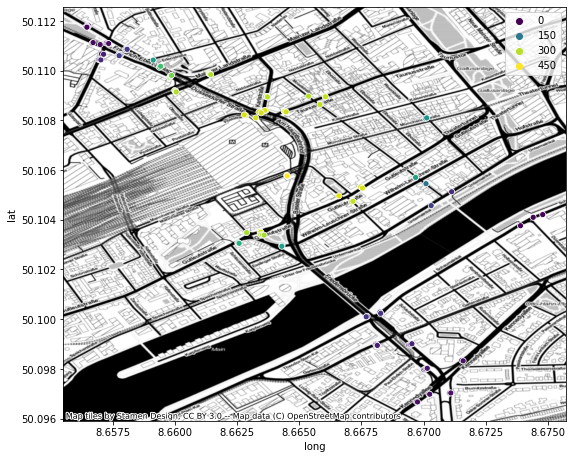

In [69]:
f, ax = plt.subplots(figsize=(9, 9))
#det_w_counts.plot(column="poi_count", 
#                scheme="quantiles", 
#                alpha=0.5,
#                legend=True, 
#                ax=ax)

sns.scatterplot(x = 'long', y = 'lat', ax = ax, data = det_w_counts1, hue = det_w_counts1['poi_count'].to_list(), palette = 'viridis')

ctx.add_basemap(ax, 
                      crs=df2_gdf.crs.to_string(), 
                       source=ctx.providers.Stamen.Toner
                     )

In [71]:
#pois_split = pois [['x', 'y', ' ']]

In [72]:

det_w_counts1['flow'] = det_w_counts1['detid'].apply(Match, args = [frankfurt_detid_average])


In [73]:
det_w_counts1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112 entries, 3441 to 3552
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   detid      112 non-null    object  
 1   length     112 non-null    float64 
 2   pos        112 non-null    float64 
 3   fclass     112 non-null    object  
 4   road       105 non-null    object  
 5   limit      112 non-null    object  
 6   citycode   112 non-null    object  
 7   lanes      112 non-null    float64 
 8   linkid     112 non-null    float64 
 9   long       112 non-null    float64 
 10  lat        112 non-null    float64 
 11  geometry   112 non-null    geometry
 12  poi_count  112 non-null    int64   
 13  flow       112 non-null    float64 
dtypes: float64(7), geometry(1), int64(1), object(5)
memory usage: 13.1+ KB


<AxesSubplot:xlabel='flow', ylabel='poi_count'>

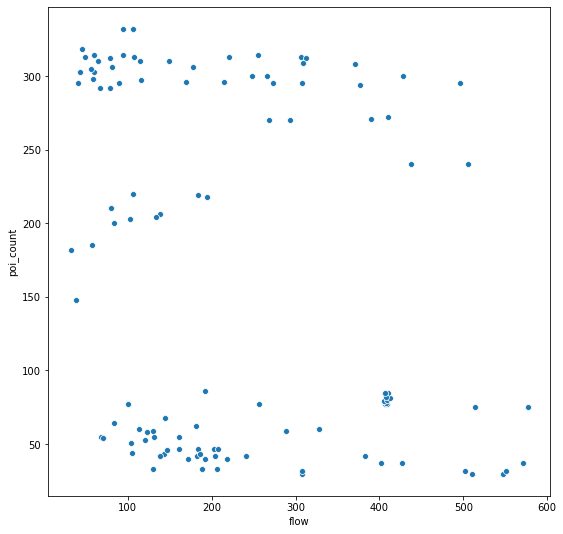

In [74]:
f, ax = plt.subplots(figsize=(9, 9))

sns.scatterplot(x = det_w_counts['flow'], y = det_w_counts['poi_count'],  ax=ax)

In [75]:
det_w_counts['poi_count'].dtype

dtype('int64')

We can visualise now the distribution of counts to get a sense of how "well-served" AirBnb properties are arranged over space (for good measure, we'll also add a legendgram):

In [76]:
pois_split = pois [['x', 'y', 'geometry', 'poi_type']]

In [77]:
pois.columns

Index(['lat', 'changeset', 'id', 'timestamp', 'tags', 'version', 'lon',
       'addr:city', 'addr:postcode', 'addr:street', 'name', 'operator',
       'public_transport', 'station', 'tunnel', 'geometry', 'osm_type',
       'access', 'area', 'bicycle', 'bridge', 'foot', 'footway', 'highway',
       'lit', 'motor_vehicle', 'oneway', 'segregated', 'smoothness', 'surface',
       'width', 'cycleway', 'sidewalk', 'poi_type', 'x', 'y'],
      dtype='object')

In [303]:
poi_count_stations = joined.groupby(['detid', 'poi_type'])['poi_type'].count()
poi_count_stations = poi_count_stations.unstack()
#poi_count_stations.columns.get_level_values
#poi_count_stations.droplevel('poi_count')
poi_count_stations


poi_type,station,cycleway,footway,pedestrian
detid,,,,
BP2_D1,6.0,3.0,195.0,6.0
BP2_D2,6.0,3.0,191.0,6.0
BP2_D3,6.0,3.0,189.0,6.0
BP4_D1(1),8.0,2.0,290.0,9.0
BP4_D10(3),6.0,1.0,207.0,6.0
...,...,...,...,...
T1_D2,8.0,3.0,283.0,9.0
T1_D3,6.0,3.0,288.0,9.0
T1_D4,6.0,3.0,288.0,9.0


In [304]:
det_w_counts = df2.merge(poi_count_stations, left_on='detid', right_index=True)

In [305]:
det_w_counts=det_w_counts.rename(columns={"pedestrian ": "pedestrian", ' station':'station', 'cycleway ': 'cycleway', 'footway ':'footway'})

In [306]:
det_w_counts = det_w_counts.fillna(value = {"pedestrian": 0, "station" : 0, "cycleway":0, "footway":0})

In [319]:
det_w_counts['station'].mean()

3.4910714285714284

In [318]:
poi_count_stations[' station'].mean()

6.982142857142857

In [152]:
print(det_w_counts.columns)

Index(['detid', 'length', 'pos', 'fclass', 'road', 'limit', 'citycode',
       'lanes', 'linkid', 'long', 'lat', 'geometry', 'station', 'cycleway',
       'footway', 'pedestrian', 'flow'],
      dtype='object')


In [141]:
det_w_counts['flow'] = det_w_counts['detid'].apply(Match, args = [frankfurt_detid_average])

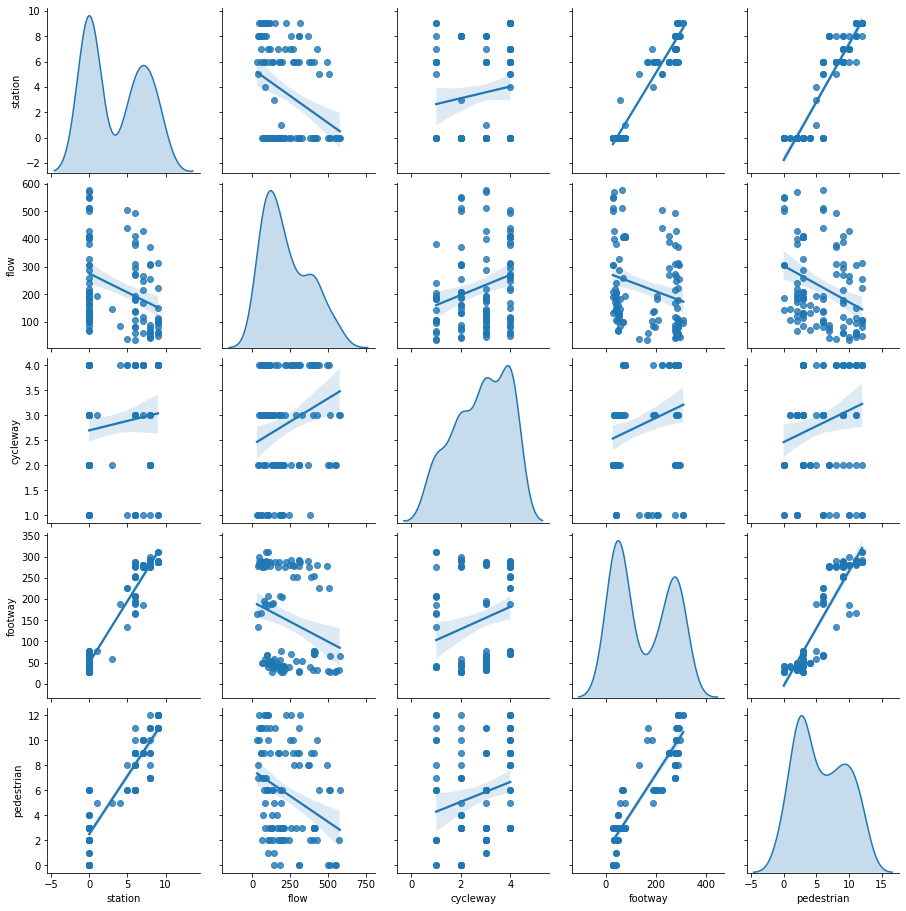

In [185]:
_ = sns.pairplot(det_w_counts[['station', 'flow', 'cycleway', 'footway', 'pedestrian']], kind='reg', diag_kind='kde')

In [156]:
cluster_df = det_w_counts.loc[:,['station', 'flow', 'cycleway', 'footway','pedestrian', 'detid']]
cluster_df = cluster_df.set_index('detid')

In [157]:
cluster_df.head()

,station,flow,cycleway,footway,pedestrian
detid,,,,,
STA4_D1(KFZ1),0.0,184.139373,2.0,42.0,3.0
STA4_D1a(KFZ1),0.0,160.647887,2.0,42.0,3.0
STA4_D2(KFZ2),0.0,203.034965,2.0,42.0,3.0
STA4_D2a(KFZ2),0.0,207.872340,2.0,42.0,3.0
STA4_D8a(KFZ8),0.0,241.062731,1.0,39.0,2.0


In [147]:
kmeans5 = cluster.KMeans(n_clusters=5)

In [403]:
np.random.seed(1234)

k5cls = kmeans5.fit(det_w_counts[['station', 'cycleway', 'footway','pedestrian']])


In [404]:
det_w_counts['k5cls'] = k5cls.labels_


In [415]:
det_w_counts['k5cls'] = det_w_counts['k5cls'].astype('str')
det_w_counts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112 entries, 3441 to 3552
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   detid       112 non-null    object  
 1   length      112 non-null    float64 
 2   pos         112 non-null    float64 
 3   fclass      112 non-null    object  
 4   road        105 non-null    object  
 5   limit       112 non-null    object  
 6   citycode    112 non-null    object  
 7   lanes       112 non-null    float64 
 8   linkid      112 non-null    float64 
 9   long        112 non-null    float64 
 10  lat         112 non-null    float64 
 11  geometry    112 non-null    geometry
 12  station     112 non-null    float64 
 13  cycleway    112 non-null    float64 
 14  footway     112 non-null    float64 
 15  pedestrian  112 non-null    float64 
 16  k5cls       112 non-null    object  
dtypes: float64(10), geometry(1), object(6)
memory usage: 15.8+ KB


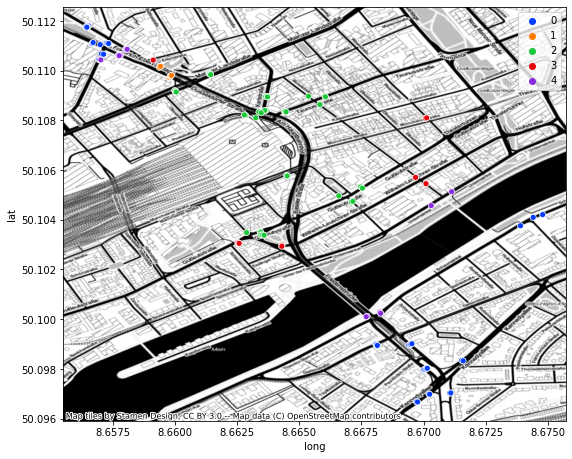

In [428]:
f, ax = plt.subplots(figsize=(9, 9))
#det_w_counts.plot(column="poi_count", 
#                scheme="quantiles", 
#                alpha=0.5,
#                legend=True, 
#                ax=ax)

sns.scatterplot(x = 'long', y = 'lat', ax = ax, data = det_w_counts, hue = det_w_counts['k5cls'].tolist(), palette = 'bright')

ctx.add_basemap(ax, 
                      crs=df2_gdf.crs.to_string(), 
                       source=ctx.providers.Stamen.Toner
                     )

In [410]:
det_w_counts[det_w_counts['k5cls'] == 2]

,detid,length,pos,fclass,road,limit,citycode,lanes,linkid,long,lat,geometry,station,cycleway,footway,pedestrian,k5cls
3453,T1_D1,0.120567,0.010235,residential,Moselstraße,0,frankfurt,1.0,5.0,8.665371,50.108970,POINT (8.66537 50.10897),7.0,3.0,279.0,9.0,2
3454,T1_D2,0.095355,0.008376,residential,Moselstraße,0,frankfurt,1.0,4.0,8.665829,50.108632,POINT (8.66583 50.10863),8.0,3.0,283.0,9.0,2
3455,T1_D3,0.221460,0.030033,secondary,Taunusstraße,50,frankfurt,1.0,6.0,8.666031,50.108971,POINT (8.66603 50.10897),6.0,3.0,288.0,9.0,2
3456,T1_D4,0.101382,0.026305,secondary,Taunusstraße,50,frankfurt,1.0,7.0,8.666053,50.108943,POINT (8.66605 50.10894),6.0,3.0,288.0,9.0,2
3464,G3_D1(KFZ1),0.188056,0.029142,secondary,Gutleutstraße,50,frankfurt,1.0,11.0,8.667472,50.105320,POINT (8.66747 50.10532),8.0,2.0,292.0,11.0,2
3465,G3_D2(KFZ1),0.188785,0.028557,secondary,Gutleutstraße,50,frankfurt,1.0,12.0,8.667540,50.105272,POINT (8.66754 50.10527),8.0,2.0,292.0,12.0,2
3466,G3_D3(KFZ2),0.170597,0.005613,residential,Wiesenhüttenplatz,50,frankfurt,1.0,13.0,8.666589,50.104960,POINT (8.66659 50.10496),8.0,2.0,298.0,10.0,2
3467,G3_D4(KFZ2),0.053260,0.004646,residential,Wiesenhüttenstraße,50,frankfurt,1.0,15.0,8.667097,50.104719,POINT (8.66710 50.10472),8.0,3.0,283.0,11.0,2
3468,G3_D5(KFZ3),0.055487,0.007537,residential,Wiesenhüttenstraße,50,frankfurt,1.0,14.0,8.667159,50.104742,POINT (8.66716 50.10474),8.0,3.0,281.0,11.0,2
3504,PR1_D8,0.086086,0.037523,primary_link,NaN,50,frankfurt,1.0,45.0,8.661362,50.109904,POINT (8.66136 50.10990),6.0,4.0,276.0,8.0,2


In [166]:
# Calculate the mean by group
k5means = det_w_counts.groupby('k5cls')[['station', 'flow', 'cycleway', 'footway','pedestrian']].mean()
# Show the table transposed (so it's not too wide)
k5means.T

k5cls,0,1,2,3,4
station,7.533333,6.125000,0.114286,0.000000,7.000000
flow,80.731792,426.735809,159.339557,435.077958,249.937886
cycleway,2.666667,3.750000,2.428571,3.086957,3.187500
footway,254.566667,259.625000,46.685714,53.608696,269.625000
pedestrian,9.300000,8.000000,2.800000,2.304348,9.312500


In [ ]:

"""
def create_model(y_array, x_array, df):
    
    # the df is split into a training and testing set
    # the test size is 0.2%, since the df is not very large
    traindf, testdf = train_test_split(df, test_size=0.2, random_state=42)
    print(f'Shape of the training set is {traindf.shape} and of the testing set is {testdf.shape}.')
    
    # creates arrays for the predicted variable and the prediction variables
    y_train = traindf[y_array]
    x_train = traindf[x_array]

    y_test = testdf[y_array]
    x_test = testdf[x_array]
    
    
    # create the X matrix by appending a column of ones to x_train and x_test
    train_data_augmented = sm.add_constant(x_train)
    test_data_augmented = sm.add_constant(x_test)

    # build the OLS model (ordinary least squares) from the training data
    OLS_model = sm.OLS(y_train, train_data_augmented)

    # do the fit and save regression info (parameters, etc) in OLS_results
    OLS_results = OLS_model.fit()
    
    # get the prediction results for the test set
    predy_test = OLS_results.predict(test_data_augmented)
    
    return [OLS_results, y_train, x_train, y_test, x_test, predy_test]
"""

In [182]:
# the df is split into a training and testing set
# the test size is 0.2%, since the df is not very large
traindf, testdf = train_test_split(det_w_counts, test_size=0.2, random_state=42)
print(f'Shape of the training set is {traindf.shape} and of the testing set is {testdf.shape}.')
    
# creates arrays for the predicted variable and the prediction variables
y_train = traindf['flow']
x_train = traindf[['station', 'cycleway', 'footway','pedestrian']]

y_test = testdf['flow']
x_test = testdf[['station', 'cycleway', 'footway','pedestrian']]

# create the X matrix by appending a column of ones to x_train
X = sm.add_constant(x_train)

# this is the same matrix as in our scratch problem!
print(X)

# build the OLS model (ordinary least squares) from the training data
toyregr_sm = sm.OLS(y_train, X)

# do the fit and save regression info (parameters, etc) in results_sm
results_sm = toyregr_sm.fit()

# pull the beta parameters out from results_sm
beta0_sm = results_sm.params[0]
beta1_sm = results_sm.params[1]

print(f'The regression coef from statsmodels are: beta_0 = {beta0_sm:8.6f} and beta_1 = {beta1_sm:8.6f}')

Shape of the training set is (89, 18) and of the testing set is (23, 18).
      const  station  cycleway  footway  pedestrian
3507    1.0      6.0       4.0    277.0         8.0
3531    1.0      6.0       1.0    205.0         6.0
3503    1.0      4.0       4.0    187.0         5.0
3463    1.0      0.0       2.0     28.0         3.0
3526    1.0      9.0       4.0    288.0        12.0
...     ...      ...       ...      ...         ...
3547    1.0      0.0       2.0     49.0         4.0
3455    1.0      6.0       3.0    288.0         9.0
3533    1.0      8.0       1.0    276.0         7.0
3492    1.0      0.0       3.0     35.0         2.0
3543    1.0      0.0       3.0     53.0         3.0

[89 rows x 5 columns]
The regression coef from statsmodels are: beta_0 = 157.576659 and beta_1 = -47.368459


In [184]:
print(results_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                   flow   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     8.174
Date:                Fri, 06 Nov 2020   Prob (F-statistic):           1.29e-05
Time:                        21:59:29   Log-Likelihood:                -555.15
No. Observations:                  89   AIC:                             1120.
Df Residuals:                      84   BIC:                             1133.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        157.5767     42.310      3.724      0.0

In [472]:
flow_cities_roads = pd.concat([F, R, M, Z, H])

In [477]:
flow_perpoi.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2329 entries, 3441 to 4326
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   detid            2329 non-null   object  
 1   length           2329 non-null   float64 
 2   pos              2329 non-null   float64 
 3   fclass           2329 non-null   object  
 4   road             2275 non-null   object  
 5   limit            2329 non-null   object  
 6   citycode         2329 non-null   object  
 7   lanes            2329 non-null   float64 
 8   linkid           2329 non-null   float64 
 9   long             2329 non-null   float64 
 10  lat              2329 non-null   float64 
 11  city             2329 non-null   object  
 12  flow             2329 non-null   float64 
 13  geometry         2329 non-null   geometry
 14  buffer_500m      2329 non-null   geometry
 15  station          2329 non-null   float64 
 16  cycleway         2329 non-null 

In [478]:
flow_cities_roads.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 56671 entries, 0 to 3262
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   osmid      56671 non-null  object  
 1   oneway     56671 non-null  bool    
 2   lanes      14306 non-null  object  
 3   ref        2987 non-null   object  
 4   name       55499 non-null  object  
 5   highway    56671 non-null  object  
 6   maxspeed   47848 non-null  object  
 7   length     56671 non-null  float64 
 8   geometry   56671 non-null  geometry
 9   access     460 non-null    object  
 10  bridge     942 non-null    object  
 11  junction   407 non-null    object  
 12  tunnel     429 non-null    object  
 13  u          56671 non-null  int64   
 14  v          56671 non-null  int64   
 15  key        56671 non-null  int32   
 16  detid      1269 non-null   object  
 17  flow       1269 non-null   float64 
 18  x          499 non-null    float64 
 19  y          499 non